## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Arthropoda - Steven</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this second notebook, we will preprocess images from the **Arthropoda** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [140]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image


In [141]:
#Libraries from Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import image_dataset_from_directory
from keras import optimizers
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks

#import tensorflow_hub as hub

#Import pre-trained models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess




# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Arthropoda Phylum.

In [142]:
# Load the DataFrame from the CSV file
arthropoda_train = pd.read_csv("/home/sacar/DeepLearning2425/train_test_splits/arthropoda_train.csv")
arthropoda_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28260809,1065329,animalia,arthropoda,apidae,arthropoda_apidae/28260809_1065329_eol-full-si...
1,29945328,1077217,animalia,arthropoda,pseudophasmatidae,arthropoda_pseudophasmatidae/29945328_1077217_...
2,14644212,463474,animalia,arthropoda,formicidae,arthropoda_formicidae/14644212_463474_eol-full...


In [143]:
# Load the DataFrame from the CSV file
arthropoda_test = pd.read_csv("/home/sacar/DeepLearning2425/train_test_splits/arthropoda_test.csv")
arthropoda_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28408206,1065346,animalia,arthropoda,apidae,arthropoda_apidae/28408206_1065346_eol-full-si...
1,28253620,1065348,animalia,arthropoda,apidae,arthropoda_apidae/28253620_1065348_eol-full-si...
2,21847584,1065348,animalia,arthropoda,apidae,arthropoda_apidae/21847584_1065348_eol-full-si...


# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

In [144]:
#Control Panel -- Choose one model to run!
is_resnet = 0
is_mobilenet = 1
is_efficientnet = 0
is_densenet = 0
is_inception = 0
is_convnext = 0

In [145]:
#Define preprocess and augmentation functions

#Function to preprocess the images
def process_image(file_path, label):
    image = tf.io.read_file(file_path) # Read the image file
    image = tf.image.decode_jpeg(image, channels=3) # Decode the JPEG image
    image = tf.image.resize(image, image_size) # Resize the image to the target size
    
    #CHANGE THIS LINE DEPENDING ON WHICH PRE-TRAINED MODEL IS BEING USED
    
    if is_resnet:
        image = resnet_preprocess(image)  # Apply ResNet50 preprocessing
        print("ResNet50 preprocessing applied")
    elif is_mobilenet: 
        image = mobilenet_preprocess(image)  # Apply MobileNetV2 preprocessing
        print
    elif is_efficientnet:
        image = efficientnet_preprocess(image)  # Apply EfficientNetB0 preprocessing
        print("EfficientNetB0 preprocessing applied")
    elif is_densenet:
        image = densenet_preprocess(image)  # Apply DenseNet121 preprocessing
        print("DenseNet121 preprocessing applied")
    elif is_inception:
        image = inception_preprocess(image)  # Apply InceptionV3 preprocessing
        print("InceptionV3 preprocessing applied")
    else:
        image = tf.cast(image, tf.float32) / 255.0  # Apply ConvNeXt / default preprocessing
        print("ConvNeXt preprocessing applied")
    
    return image, label


#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)


In [146]:
#Define some stuff
num_classes = arthropoda_train['family'].nunique() #number of classes = number of families
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)
num_classes = 17  



In [147]:
root_dir = "/home/sacar/DeepLearning2425/rare_species"

#Get the file paths and labels for the training and test set
arthropoda_train['full_path'] = arthropoda_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
arthropoda_test['full_path'] = arthropoda_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

file_paths_train = arthropoda_train['full_path'].tolist()
labels_train = arthropoda_train['family'].tolist()

file_paths_test = arthropoda_test['full_path'].tolist()
labels_test = arthropoda_test['family'].tolist()

#Map the labels to integers
label_names = sorted(set(labels_train)) # Get the unique labels
label_to_index = {name: i for i, name in enumerate(label_names)} # Create a mapping from labels to integers
labels_train = [label_to_index[label] for label in labels_train]
labels_test = [label_to_index[label] for label in labels_test]

print(file_paths_train[:5])
print(labels_train[:5])
print(file_paths_test[:5])
print(labels_test[:5])

['/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/28260809_1065329_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_pseudophasmatidae/29945328_1077217_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_formicidae/14644212_463474_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_pseudophasmatidae/29945335_1077217_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_papilionidae/21035374_130548_eol-full-size-copy.jpg']
[0, 13, 5, 13, 10]
['/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/28408206_1065346_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/28253620_1065348_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/21847584_1065348_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_formicidae/14681521_403723_eol-full-size-copy.jpg', '/home/sacar/DeepLe

In [148]:
#Create the tensorflow datasets

#Load data
data = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
data = data.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=False, seed=42) # Shuffle the dataset

#Create train/val
train_size = int(0.8 * len(file_paths_train)) #80% for training, 20% for validation
train = data.take(train_size) # Take the first 80% for training
val = data.skip(train_size) # Skip the first 80% for validation

#Training preprocess pipeline
train = train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE) # Map the function to the dataset
train = train.cache() # Cache the dataset for faster access
train = train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) # Map the function to the dataset
train = train.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=True, seed=42).batch(8).prefetch(buffer_size=tf.data.AUTOTUNE) #shuffle and batch

#Validation preprocess pipeline
val = val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE) # Map the function to the dataset
val = val.cache() # Cache the dataset for faster access
val = val.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE) #batch


#Test preprocess pipeline
test = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
test = test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test = test.cache().batch(8).prefetch(tf.data.AUTOTUNE)

In [149]:
for image, label in train.take(3):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

for image, label in test.take(3):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Image shape: (8, 224, 224, 3)
Label: [0 8 5 5 2 8 0 5]
Image shape: (8, 224, 224, 3)
Label: [4 0 5 5 5 6 0 1]
Image shape: (8, 224, 224, 3)
Label: [ 3  5  3 11  6 10  1  3]
Image shape: (8, 224, 224, 3)
Label: [ 0  0  0  5  9  0 16  5]
Image shape: (8, 224, 224, 3)
Label: [ 5  5  0 16  6  0 11  0]
Image shape: (8, 224, 224, 3)
Label: [ 0  5 13  5  5  8  5  0]


2025-04-10 18:06:52.995363: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-10 18:06:53.003139: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [150]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
# Print GPU devices detected
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f" GPU(s) detected: {[gpu.name for gpu in gpus]}")
else:
    print(" No GPU detected by TensorFlow.")

# Resnet50

In [ ]:
if is_resnet == 1:
    # 1. Load the ResNet50 base model (without top classifier)
    base_model = ResNet50(
        weights='imagenet',          # Use ImageNet pretrained weights
        include_top=False,           # Exclude the default final dense layer
        input_shape=(224, 224, 3)    # Adjust to match your input images
    )

    # 2. Freeze the base model so we only train the classifier head
    base_model.trainable = False

    # 3. Build custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)


    # 4. Create the full model
    model = models.Model(inputs=base_model.input, outputs=output)

    # 5. Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',  # Use sparse version for integer labels
        metrics=['accuracy']
    )


    # 6. Train the model
    history = model.fit(
        train,
        epochs=100,
        validation_data=val,
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
        verbose=1
    )

    # 7. Save the model
    model.save("resnet50_rare_species_model.h5")

    plot_filename = 'resnet50_rare_species_1.png' # Match naming convention
    plt.savefig(plot_filename)
    print(f"Training plot saved to {plot_filename}")
    
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

    #Plot training & validation F1 score
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()



# MobileNetV2

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1735 - loss: 3.0897

74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.1748 - loss: 3.0858 - val_accuracy: 0.3581 - val_loss: 2.2745 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3753 - loss: 2.3148

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.3756 - loss: 2.3140 - val_accuracy: 0.4054 - val_loss: 2.0618 - learning_rate: 1.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3781 - loss: 2.2003

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3783 - loss: 2.1989 - val_accuracy: 0.4324 - val_loss: 1.8867 - learning_rate: 1.0000e-04
Epoch 4/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4608 - loss: 1.7990

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4603 - loss: 1.8007 - val_accuracy: 0.4595 - val_loss: 1.7921 - learning_rate: 1.0000e-04
Epoch 5/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5312 - loss: 1.6366

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5303 - loss: 1.6391 - val_accuracy: 0.4797 - val_loss: 1.6906 - learning_rate: 1.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5076 - loss: 1.6187

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5075 - loss: 1.6187 - val_accuracy: 0.5203 - val_loss: 1.5839 - learning_rate: 1.0000e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5211 - loss: 1.5826

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5213 - loss: 1.5818 - val_accuracy: 0.5541 - val_loss: 1.5061 - learning_rate: 1.0000e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5426 - loss: 1.5282

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5427 - loss: 1.5282 - val_accuracy: 0.5878 - val_loss: 1.4015 - learning_rate: 1.0000e-04
Epoch 9/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5743 - loss: 1.4417

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5747 - loss: 1.4397 - val_accuracy: 0.5946 - val_loss: 1.3396 - learning_rate: 1.0000e-04
Epoch 10/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5535 - loss: 1.4074

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5543 - loss: 1.4061 - val_accuracy: 0.6081 - val_loss: 1.3039 - learning_rate: 1.0000e-04
Epoch 11/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6278 - loss: 1.2422

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6278 - loss: 1.2445 - val_accuracy: 0.6149 - val_loss: 1.2905 - learning_rate: 1.0000e-04
Epoch 12/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6183 - loss: 1.2176

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6183 - loss: 1.2186 - val_accuracy: 0.6284 - val_loss: 1.2354 - learning_rate: 1.0000e-04
Epoch 13/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6516 - loss: 1.1573

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6517 - loss: 1.1583 - val_accuracy: 0.6554 - val_loss: 1.1645 - learning_rate: 1.0000e-04
Epoch 14/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6773 - loss: 1.1081

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6769 - loss: 1.1091 - val_accuracy: 0.6554 - val_loss: 1.1389 - learning_rate: 1.0000e-04
Epoch 15/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6451 - loss: 1.1189 - val_accuracy: 0.6757 - val_loss: 1.1416 - learning_rate: 1.0000e-04
Epoch 16/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6657 - loss: 1.1143

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6668 - loss: 1.1124 - val_accuracy: 0.6486 - val_loss: 1.1051 - learning_rate: 1.0000e-04
Epoch 17/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6933 - loss: 0.9850

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6934 - loss: 0.9856 - val_accuracy: 0.6486 - val_loss: 1.0654 - learning_rate: 1.0000e-04
Epoch 18/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7214 - loss: 1.0067 - val_accuracy: 0.6351 - val_loss: 1.1088 - learning_rate: 1.0000e-04
Epoch 19/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6835 - loss: 1.0499

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6841 - loss: 1.0498 - val_accuracy: 0.6486 - val_loss: 1.0434 - learning_rate: 1.0000e-04
Epoch 20/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7378 - loss: 0.9508

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7357 - loss: 0.9517 - val_accuracy: 0.6689 - val_loss: 1.0425 - learning_rate: 1.0000e-04
Epoch 21/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6875 - loss: 0.9798 - val_accuracy: 0.6419 - val_loss: 1.0648 - learning_rate: 1.0000e-04
Epoch 22/100
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7182 - loss: 0.9231

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7183 - loss: 0.9238 - val_accuracy: 0.6757 - val_loss: 1.0163 - learning_rate: 1.0000e-04
Epoch 23/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7271 - loss: 0.9618

74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7270 - loss: 0.9617 - val_accuracy: 0.6689 - val_loss: 0.9836 - learning_rate: 1.0000e-04
Epoch 24/100
71/74 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7414 - loss: 0.8542

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7406 - loss: 0.8562 - val_accuracy: 0.7027 - val_loss: 0.9370 - learning_rate: 1.0000e-04
Epoch 25/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7360 - loss: 0.8836 - val_accuracy: 0.6959 - val_loss: 0.9925 - learning_rate: 1.0000e-04
Epoch 26/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7279 - loss: 0.8069 - val_accuracy: 0.6959 - val_loss: 0.9703 - learning_rate: 1.0000e-04
Epoch 27/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7452 - loss: 0.8513 - val_accuracy: 0.6892 - val_loss: 0.9886 - learning_rate: 1.0000e-04
Epoch 28/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7246 - loss: 0.8782 - val_accuracy: 0.6757 - val_loss: 0.9703 - learning_rate: 1.0000e-04
Epoch 29/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7728 - loss: 0.7866 - val_accuracy: 0.6757 - val_loss: 1.0239 - learning_rate: 1.0000e-04
Epoch 30/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7241

74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 277ms/step - accuracy: 0.5953 - loss: 1.4320 - val_accuracy: 0.7230 - val_loss: 0.8681 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6342 - loss: 1.2231

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6344 - loss: 1.2224 - val_accuracy: 0.7365 - val_loss: 0.8163 - learning_rate: 1.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7038 - loss: 0.9853 - val_accuracy: 0.7500 - val_loss: 0.8509 - learning_rate: 1.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7234 - loss: 0.8513 - val_accuracy: 0.7770 - val_loss: 0.8368 - learning_rate: 1.0000e-04
Epoch 5/100
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7738 - loss: 0.7844

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7728 - loss: 0.7863 - val_accuracy: 0.7770 - val_loss: 0.7549 - learning_rate: 1.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7568 - loss: 0.7786 - val_accuracy: 0.7770 - val_loss: 0.8431 - learning_rate: 1.0000e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8174 - loss: 0.6190 - val_accuracy: 0.7703 - val_loss: 0.8934 - learning_rate: 1.0000e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8020 - loss: 0.6257 - val_accuracy: 0.8041 - val_loss: 0.7634 - learning_rate: 1.0000e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8603 - loss: 0.4580 - val_accuracy: 0.7838 - val_loss: 0.8879 - learning_rate: 1.0000e-04
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8275 - loss: 0.5438 - val_accuracy: 0.7635 - val_loss: 0.8575 - learning_rate: 1.0000e-04
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8758 - l

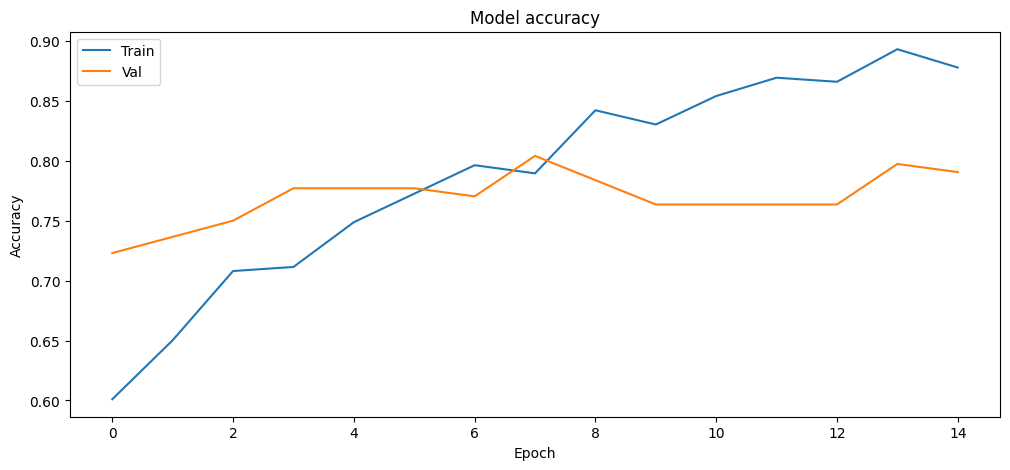

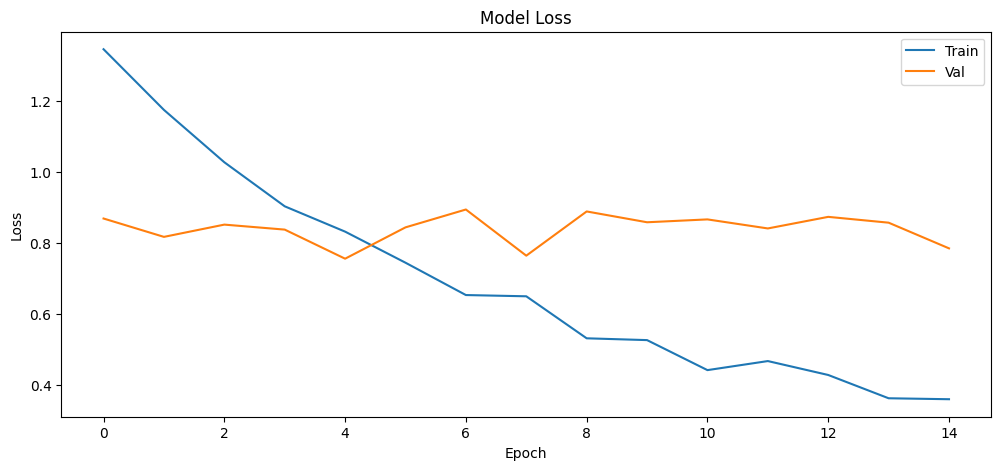

Training plot saved to mobilenetV2_rare_species_1.png


<Figure size 640x480 with 0 Axes>

In [ ]:
if is_mobilenet == 1:
    # Load base model without top layer
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),  # Match your resized image shape
        include_top=False,         # Don't include the original classifier
        weights='imagenet'         # Use ImageNet-pretrained weights
    )

    # Define callbacks
    my_callbacks = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
    ]


    #Phase 1: 
    # Freeze base model so we only train the new layers for now
    base_model.trainable = False

    # Build custom model
    model = models.Sequential([
        base_model,                                # Feature extractor
        layers.GlobalAveragePooling2D(),           # Pool over spatial dimensions
        layers.Dropout(0.5),                       # Regularization layer
        layers.Dense(256, activation='relu'),      # Fully connected layer
        layers.Dense(num_classes, activation='softmax')      # Output layer (5 mollusk families)
    ])

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',  # Use sparse version for integer labels
        metrics=['accuracy'],
    )

    # Train the model
    history1 = model.fit(
        train,
        validation_data=val,
        callbacks = my_callbacks,
        epochs=100,           # Start small, increase if needed
        verbose=1
    )

    #Phase 2:
    # Unfreeze everything but the first 100 layers
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',  # Use sparse version for integer labels
        metrics=['accuracy'],
    )

    # Train the model
    history2 = model.fit(
        train,
        validation_data=val,
        callbacks = my_callbacks,
        epochs=100,           # Start small, increase if needed
        verbose=1
    )

    # Save the model
    model.save("mobilenetv2_rare_species_model.h5")

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history2.history['accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

    '''
    #Plot training & validation F1 score
    plt.figure(figsize=(12, 5))
    plt.plot(history2.history['f1_score'])
    plt.plot(history2.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
    '''
    
    #Plot training & validation loss
    plt.figure(figsize=(12, 5))
    plt.plot(history2.history['loss'])
    plt.plot(history2.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()


    plot_filename = 'mobilenetV2_rare_species_1.png' # Match naming convention
    plt.savefig(plot_filename)
    print(f"Training plot saved to {plot_filename}")

# EfficientNetB0

In [154]:
if is_efficientnet == 1:
    # Load EfficientNetB0 as base model
    base_model = EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model
    base_model.trainable = False

    # Build classifier on top
    model = models.Sequential([
        base_model,                                # Feature extractor
        layers.GlobalAveragePooling2D(),           # Pool features
        layers.Dropout(0.3),                       # Regularization
        layers.Dense(128, activation='relu'),      # Fully connected layer
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print summary
    model.summary()

    # Train it
    history = model.fit(
        train,
        validation_data=val,
        epochs=100,         # Adjust as needed
        verbose=1
    )

    #Save the model
    model.save("efficientnet_rare_species_model.h5")
    
    plot_filename = 'efficientnet_rare_species_1.png' # Match naming convention
    plt.savefig(plot_filename)
    print(f"Training plot saved to {plot_filename}")

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

    #Plot training & validation F1 score
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()


# DenseNet

In [155]:
if is_densenet == 1:
    base_model = DenseNet121(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(
        train,
        validation_data=val,
        epochs=100,
        verbose=1
    )

    # Save the model
    model.save("densenet_rare_species_model.h5")

    plot_filename = 'densenet_rare_species_1.png' # Match naming convention
    plt.savefig(plot_filename)
    print(f"Training plot saved to {plot_filename}")

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

    #Plot training & validation F1 score
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

# InceptionV3

In [156]:
if is_inception == 1:
    base_model = InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(
        train,
        validation_data=val,
        epochs=100,
        verbose=1
    )

    #Save the model
    model.save("inception_rare_species_model.h5")

    plot_filename = 'inceptionV3_rare_species_1.png' # Match naming convention
    plt.savefig(plot_filename)
    print(f"Training plot saved to {plot_filename}")

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

    #Plot training & validation F1 score
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

# Convnext

In [157]:
if is_convnext == 1:
    base_model = tf.keras.Sequential([
        hub.KerasLayer(
            "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224/1",
            trainable=False,
            input_shape=(224, 224, 3)
        )
    ])

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(
        train,
        validation_data=val,
        epochs=100,
        verbose=1)
    
    #Save the model
    model.save("convnext_rare_species_model.h5")

    plot_filename = 'convnext_rare_species_1.png' # Match naming convention
    plt.savefig(plot_filename)
    print(f"Training plot saved to {plot_filename}")

    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

    #Plot training & validation F1 score
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()